In [3]:
import pandas as pd
import numpy as np
import re
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings('ignore')

# Load Data
df = pd.read_csv("/content/IMDB Dataset.csv", on_bad_lines='skip', engine='python', quotechar='"')

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    return text

# Apply cleaning
df['clean_review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['clean_review'])
y = df['label']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

# Analysis
results_df = pd.DataFrame({
    'Review': df.loc[y_test.index, 'review'],
    'Actual': y_test,
    'Predicted': y_pred
})

misclassified = results_df[results_df['Actual'] != results_df['Predicted']]
print(f"Total Misclassified Reviews: {len(misclassified)}")

if not misclassified.empty:
    example = misclassified.iloc[0]
    print(f"Review: {example['Review'][:200]}...")
    print(f"Actual: {example['Actual']}")
    print(f"Predicted: {example['Predicted']}")

Model Accuracy: 0.8868
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      3022
           1       0.88      0.90      0.89      3154

    accuracy                           0.89      6176
   macro avg       0.89      0.89      0.89      6176
weighted avg       0.89      0.89      0.89      6176

Total Misclassified Reviews: 699
Review: Ok, so there's always people out there that seem to make it a point not to like movies because they're good, but instead choose to like movies based on how depressing or boring they can be, or whether...
Actual: 1
Predicted: 0


In [6]:
!pip install gensim

import pandas as pd
import numpy as np
import re
import warnings
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings('ignore')

# Load Data
df = pd.read_csv("/content/IMDB Dataset.csv", on_bad_lines='skip', engine='python', quotechar='"')

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    return text

# Apply cleaning
df['clean_review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Prepare Data for Word2Vec (Tokenization)
sentences = [row.split() for row in df['clean_review']]

# Train Word2Vec Model
# vector_size=100: Each word is represented by 100 numbers
# window=5: Considers 5 words to the left and right for context
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Function to average word vectors for a whole review
def get_document_vector(tokens):
    vectors = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

# Create Feature Matrix X
X = np.array([get_document_vector(s) for s in sentences])
y = df['label']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy (Word2Vec): {accuracy:.4f}")
print(classification_report(y_test, y_pred))

# Misclassification Analysis
results_df = pd.DataFrame({
    'Review': df.loc[y_test.index, 'review'],
    'Actual': y_test,
    'Predicted': y_pred
})

misclassified = results_df[results_df['Actual'] != results_df['Predicted']]
print(f"Total Misclassified Reviews: {len(misclassified)}")

if not misclassified.empty:
    example = misclassified.iloc[0]
    print(f"Review: {example['Review'][:200]}...")
    print(f"Actual: {example['Actual']}")
    print(f"Predicted: {example['Predicted']}")

Model Accuracy (Word2Vec): 0.8462
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3022
           1       0.85      0.85      0.85      3154

    accuracy                           0.85      6176
   macro avg       0.85      0.85      0.85      6176
weighted avg       0.85      0.85      0.85      6176

Total Misclassified Reviews: 950
Review: Ok, so there's always people out there that seem to make it a point not to like movies because they're good, but instead choose to like movies based on how depressing or boring they can be, or whether...
Actual: 1
Predicted: 0


In [9]:
import pandas as pd
import numpy as np
import re
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

warnings.filterwarnings('ignore')

df = pd.read_csv("/content/IMDB Dataset.csv", on_bad_lines='skip', engine='python', quotechar='"')

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    return text

df['clean_review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['clean_review'])
sequences = tokenizer.texts_to_sequences(df['clean_review'])
X = pad_sequences(sequences, maxlen=200)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=200),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1, verbose=1)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Project 3 Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Epoch 1/3
348/348 ━━━━━━━━━━━━━━━━━━━━ 112s 308ms/step - accuracy: 0.6960 - loss: 0.5620 - val_accuracy: 0.8251 - val_loss: 0.3900
Epoch 2/3
348/348 ━━━━━━━━━━━━━━━━━━━━ 107s 307ms/step - accuracy: 0.8551 - loss: 0.3509 - val_accuracy: 0.8393 - val_loss: 0.3705
Epoch 3/3
348/348 ━━━━━━━━━━━━━━━━━━━━ 109s 313ms/step - accuracy: 0.8629 - loss: 0.3282 - val_accuracy: 0.8324 - val_loss: 0.3895
193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step
Project 3 Accuracy: 0.8447
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      3022
           1       0.81      0.91      0.86      3154

    accuracy                           0.84      6176
   macro avg       0.85      0.84      0.84      6176
weighted avg       0.85      0.84      0.84      6176



In [11]:
import pandas as pd
import numpy as np
import re
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. LOAD KNOWLEDGE BASE (IMDB DATASET)
# ---------------------------------------------------------
# We treat the entire dataset as our "Library" of information.
df = pd.read_csv("/content/IMDB Dataset.csv", on_bad_lines='skip', engine='python', quotechar='"')

# Use a subset for faster searching in this demo
df_kb = df.head(5000).copy()

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    return text

df_kb['clean_review'] = df_kb['review'].apply(clean_text)

print(f"Knowledge Base Loaded: {len(df_kb)} documents.")

# ---------------------------------------------------------
# 2. CREATE VECTOR INDEX (The 'Database')
# ---------------------------------------------------------
# We turn every review into a vector so we can search mathematically.
# TF-IDF is used here as a simple, effective embedding method.
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
knowledge_base_vectors = vectorizer.fit_transform(df_kb['clean_review'])

# ---------------------------------------------------------
# 3. DEFINE RETRIEVAL FUNCTION
# ---------------------------------------------------------
def retrieve_documents(query, top_k=3):
    """
    1. Vectorize the User's Query.
    2. Compare query vector vs. all 5000 review vectors (Cosine Similarity).
    3. Return the top_k most similar reviews.
    """
    # Clean and Vectorize Query
    clean_query = clean_text(query)
    query_vec = vectorizer.transform([clean_query])

    # Calculate Similarity (Higher score = more relevant)
    similarities = cosine_similarity(query_vec, knowledge_base_vectors).flatten()

    # Get indices of top_k matches (sorted descending)
    top_indices = similarities.argsort()[-top_k:][::-1]

    results = []
    for idx in top_indices:
        results.append({
            'score': similarities[idx],
            'review': df_kb.iloc[idx]['review']
        })
    return results

# ---------------------------------------------------------
# 4. DEFINE AUGMENTATION FUNCTION (Prompt Engineering)
# ---------------------------------------------------------
def generate_rag_prompt(query, retrieved_docs):
    """
    Constructs a prompt for an LLM (like GPT-4) using the retrieved data.
    """
    context_str = ""
    for i, doc in enumerate(retrieved_docs):
        context_str += f"\nDocument {i+1}: {doc['review'][:300]}...\n"

    prompt = f"""
    [System]: You are a helpful movie expert. Use the provided context to answer the user's question.

    [Context Documents]:
    {context_str}

    [User Question]: {query}

    [Answer]:
    """
    return prompt

# ---------------------------------------------------------
# 5. DEMONSTRATION
# ---------------------------------------------------------
# Scenario: User asks a specific question.
user_query = "What are some scary movies with zombies?"

print(f"--- Step 1: User asks: '{user_query}' ---")

# Step 2: Retrieve relevant info
results = retrieve_documents(user_query)
print(f"\n--- Step 2: System Retrieves {len(results)} Relevant Reviews ---")
for i, res in enumerate(results):
    print(f"Match #{i+1} (Score: {res['score']:.2f}): {res['review'][:100]}...")

# Step 3: Generate Prompt
rag_prompt = generate_rag_prompt(user_query, results)
print("\n--- Step 3: Final RAG Prompt Generated (To be sent to LLM) ---")
print(rag_prompt)

Knowledge Base Loaded: 5000 documents.
--- Step 1: User asks: 'What are some scary movies with zombies?' ---

--- Step 2: System Retrieves 3 Relevant Reviews ---
Match #1 (Score: 0.41): Down at the Movie Gallery, I saw a flick I just had to see. It looked like a fun low-budget horror/a...
Match #2 (Score: 0.39): The only reason I gave this episode of "Masters of Horror" a 2 instead of a 1 is because the two lea...
Match #3 (Score: 0.39): Now, I'm a big fan of Zombie movies. I admit Zombie movies usually aren't all that good, but I like ...

--- Step 3: Final RAG Prompt Generated (To be sent to LLM) ---

    [System]: You are a helpful movie expert. Use the provided context to answer the user's question.

    [Context Documents]:
    
Document 1: Down at the Movie Gallery, I saw a flick I just had to see. It looked like a fun low-budget horror/action/western that I could get into. Yeah, I knew it would suck, but I rented it anyway hoping for laughs. Only a few laughs were to be found. T

In [14]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv("/content/IMDB Dataset.csv", on_bad_lines='skip', engine='python', quotechar='"')

def get_zero_shot_prompt(review_text):
    prompt = f"""
Classify the sentiment of the following movie review as either 'Positive' or 'Negative'.

Review: "{review_text}"
Sentiment:
"""
    return prompt.strip()

def get_few_shot_prompt(target_review, example_reviews, example_sentiments):
    prompt = "Classify the sentiment of the movie reviews.\n\n"

    for rev, sent in zip(example_reviews, example_sentiments):
        prompt += f"Review: \"{rev}\"\nSentiment: {sent}\n\n"

    prompt += f"Review: \"{target_review}\"\nSentiment:"
    return prompt.strip()

target_review = df.iloc[10]['review']

print("--- Zero-Shot Prompt ---")
print(get_zero_shot_prompt(target_review))

example_indices = [0, 1, 2, 20000, 20001]
examples = df.iloc[example_indices]['review'].tolist()
sentiments = df.iloc[example_indices]['sentiment'].tolist()

print("\n\n--- Few-Shot Prompt ---")
print(get_few_shot_prompt(target_review, examples, sentiments))

--- Zero-Shot Prompt ---
Classify the sentiment of the following movie review as either 'Positive' or 'Negative'.

Review: "Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet""
Sentiment:


--- Few-Shot Prompt ---
Classify the sentiment of the movie reviews.

Review: "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about O

In [19]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Load & Clean Data
df = pd.read_csv("IMDB Dataset.csv", on_bad_lines='skip', engine='python', quotechar='"')
df_small = df.head(2000).copy() # Subset for demonstration

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    return text

df_small['clean_review'] = df_small['review'].apply(clean_text)

# ==========================================
# PROJECT 4: DATABASE RETRIEVAL SIMULATION
# ==========================================
print("--- Executing Project 4 (Retrieval) ---")

# Build the "Database" (Vector Index)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
database_vectors = vectorizer.fit_transform(df_small['clean_review'])

def search_database(query):
    # Convert query to vector
    query_vec = vectorizer.transform([clean_text(query)])
    # Compare query vs all 2000 reviews
    similarities = cosine_similarity(query_vec, database_vectors).flatten()
    # Find best match
    top_idx = similarities.argsort()[-1]
    return df_small.iloc[top_idx]['review']

# Run Search
query = "movies about zombies and ghosts"
match = search_database(query)
print(f"Query: '{query}'")
print(f"Retrieved: \"{match[:100]}...\"")

# ==========================================
# PROJECT 5: PROMPT GENERATION
# ==========================================
print("\n--- Executing Project 5 (Prompt Engineering) ---")

target_review = df_small.iloc[10]['review']

# Few-Shot Prompt Construction
pos_example = df_small[df_small['sentiment']=='positive'].iloc[0]['review'][:80]
neg_example = df_small[df_small['sentiment']=='negative'].iloc[0]['review'][:80]

prompt = f"""
Task: Classify sentiment.

Example 1: "{pos_example}..." -> Positive
Example 2: "{neg_example}..." -> Negative

Target: "{target_review[:100]}..." ->
"""
print("Generated Prompt:")
print(prompt)

--- Executing Project 4 (Retrieval) ---
Query: 'movies about zombies and ghosts'
Retrieved: "Down at the Movie Gallery, I saw a flick I just had to see. It looked like a fun low-budget horror/a..."

--- Executing Project 5 (Prompt Engineering) ---
Generated Prompt:

Task: Classify sentiment.

Example 1: "One of the other reviewers has mentioned that after watching just 1 Oz episode y..." -> Positive
Example 2: "Basically there's a family where a little boy (Jake) thinks there's a zombie in ..." -> Negative

Target: "Phil the Alien is one of those quirky films where the humour is based around the oddness of everythi..." ->



Loading Data...

Running Model 1: TF-IDF + Logistic Regression...
Accuracy: 0.8670

Running Model 2: Word2Vec + Logistic Regression...
Accuracy: 0.7330

Running Model 3: LSTM Neural Network...
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
Accuracy: 0.8070

Generating Comparison Dashboard...


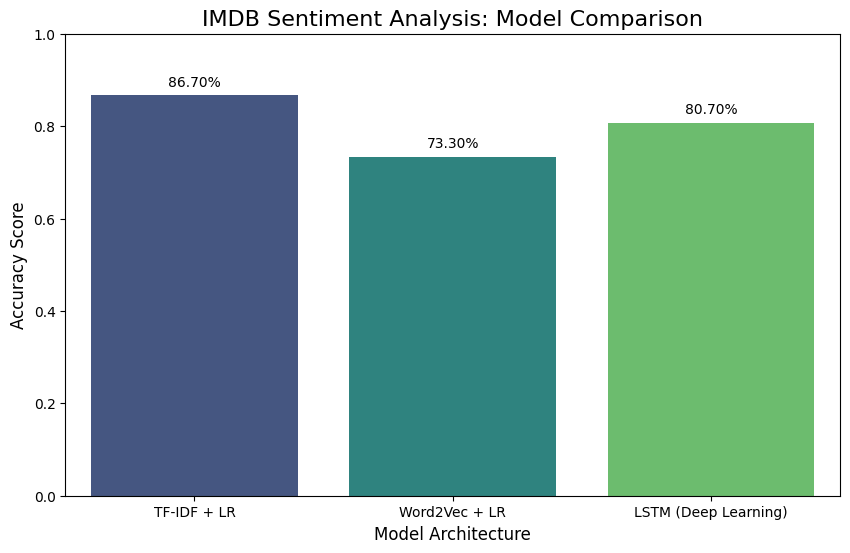

In [21]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. SETUP & DATA LOADING
# ---------------------------------------------------------
print("Loading Data...")
df = pd.read_csv("IMDB Dataset.csv", on_bad_lines='skip', engine='python', quotechar='"')

# Use a subset for faster demonstration (Change to 50000 for full run)
SUBSET_SIZE = 5000
df = df.head(SUBSET_SIZE).copy()

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    return text

df['clean_review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Global Train/Test Split (To ensure fair comparison)
X_raw = df['clean_review']
y = df['label'].values
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

model_scores = {}

# ---------------------------------------------------------
# MODEL 1: TF-IDF + Logistic Regression (Baseline)
# ---------------------------------------------------------
print("\nRunning Model 1: TF-IDF + Logistic Regression...")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

m1 = LogisticRegression(max_iter=1000)
m1.fit(X_train_tfidf, y_train)
acc_m1 = accuracy_score(y_test, m1.predict(X_test_tfidf))
model_scores['TF-IDF + LR'] = acc_m1
print(f"Accuracy: {acc_m1:.4f}")

# ---------------------------------------------------------
# MODEL 2: Word2Vec + Logistic Regression (Semantic)
# ---------------------------------------------------------
print("\nRunning Model 2: Word2Vec + Logistic Regression...")
# Tokenize
train_tokens = [row.split() for row in X_train_raw]
test_tokens = [row.split() for row in X_test_raw]

# Train Word2Vec
w2v = Word2Vec(train_tokens, vector_size=100, window=5, min_count=2, workers=4)

def get_avg_vector(tokens, model):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if vecs:
        return np.mean(vecs, axis=0)
    return np.zeros(100)

X_train_w2v = np.array([get_avg_vector(t, w2v) for t in train_tokens])
X_test_w2v = np.array([get_avg_vector(t, w2v) for t in test_tokens])

m2 = LogisticRegression(max_iter=1000)
m2.fit(X_train_w2v, y_train)
acc_m2 = accuracy_score(y_test, m2.predict(X_test_w2v))
model_scores['Word2Vec + LR'] = acc_m2
print(f"Accuracy: {acc_m2:.4f}")

# ---------------------------------------------------------
# MODEL 3: LSTM (Deep Learning)
# ---------------------------------------------------------
print("\nRunning Model 3: LSTM Neural Network...")
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_raw)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_raw), maxlen=200)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test_raw), maxlen=200)

m3 = Sequential([
    Embedding(5000, 128, input_length=200),
    LSTM(64, dropout=0.2),
    Dense(1, activation='sigmoid')
])
m3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
m3.fit(X_train_seq, y_train, epochs=3, batch_size=64, verbose=0)

y_pred_prob = m3.predict(X_test_seq)
y_pred_m3 = (y_pred_prob > 0.5).astype(int)
acc_m3 = accuracy_score(y_test, y_pred_m3)
model_scores['LSTM (Deep Learning)'] = acc_m3
print(f"Accuracy: {acc_m3:.4f}")

# ---------------------------------------------------------
# 4. VISUALIZATION DASHBOARD
# ---------------------------------------------------------
print("\nGenerating Comparison Dashboard...")

results_df = pd.DataFrame(list(model_scores.items()), columns=['Model', 'Accuracy'])

plt.figure(figsize=(10, 6))

sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.ylim(0, 1.0)
plt.title('IMDB Sentiment Analysis: Model Comparison', fontsize=16)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('Model Architecture', fontsize=12)

# Add text labels on bars
for index, row in results_df.iterrows():
    plt.text(index, row.Accuracy + 0.02, f"{row.Accuracy:.2%}", color='black', ha="center")

plt.show()

In [23]:
import pandas as pd
import re
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
# 1. TRAIN & SAVE THE BEST MODEL
# ---------------------------------------------------------
print("Training final model for deployment...")

# Load & Clean
df = pd.read_csv("IMDB Dataset.csv", on_bad_lines='skip', engine='python', quotechar='"')
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    return text

df['clean_review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Train (using the full dataset this time)
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['clean_review'])
y = df['label']

model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# SAVE to disk
print("Saving model and vectorizer...")
joblib.dump(model, 'imdb_sentiment_model.pkl')
joblib.dump(tfidf, 'imdb_tfidf_vectorizer.pkl')
print("files saved: 'imdb_sentiment_model.pkl', 'imdb_tfidf_vectorizer.pkl'")

# ---------------------------------------------------------
# 2. THE "APP" (INFERENCE SCRIPT)
# ---------------------------------------------------------
# This part simulates what happens in a real product (e.g., Streamlit app)
print("\n" + "="*40)
print("STARTING PREDICTION APP")
print("="*40)

def predict_sentiment(text):
    # 1. Load Model & Vectorizer (Simulating a separate process)
    loaded_model = joblib.load('imdb_sentiment_model.pkl')
    loaded_tfidf = joblib.load('imdb_tfidf_vectorizer.pkl')

    # 2. Preprocess Input
    clean_input = clean_text(text)

    # 3. Vectorize
    input_vec = loaded_tfidf.transform([clean_input])

    # 4. Predict
    prediction = loaded_model.predict(input_vec)[0]
    probability = loaded_model.predict_proba(input_vec)[0][prediction]

    sentiment = "POSITIVE" if prediction == 1 else "NEGATIVE"
    return sentiment, probability

# Interactive Loop (Type 'exit' to stop)
# In a notebook, we'll just run a few examples automatically
examples = [
    "This movie was absolutely amazing! I loved the acting.",
    "I fell asleep halfway through. The plot was boring and predictable.",
    "It was okay, not the best but certainly not the worst."
]

for review in examples:
    result, conf = predict_sentiment(review)
    print(f"\nReview: '{review}'")
    print(f"Prediction: {result} (Confidence: {conf:.2%})")

Training final model for deployment...
Saving model and vectorizer...
files saved: 'imdb_sentiment_model.pkl', 'imdb_tfidf_vectorizer.pkl'

STARTING PREDICTION APP

Review: 'This movie was absolutely amazing! I loved the acting.'
Prediction: POSITIVE (Confidence: 96.64%)

Review: 'I fell asleep halfway through. The plot was boring and predictable.'
Prediction: NEGATIVE (Confidence: 99.12%)

Review: 'It was okay, not the best but certainly not the worst.'
Prediction: NEGATIVE (Confidence: 93.40%)


In [27]:
!wget -q -O - ipv4.icanhazip.com

34.28.250.145


In [32]:
!pip install -q streamlit
!npm install -g localtunnel
import joblib

⠙⠹⠸⠼⠴⠦⠧
changed 22 packages in 893ms
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧

In [33]:
%%writefile app.py
import streamlit as st
import joblib
import re
import os

# 1. Load Models
@st.cache_resource
def load_assets():
    # Check if files exist before loading to avoid crashes
    if os.path.exists('imdb_sentiment_model.pkl'):
        model = joblib.load('imdb_sentiment_model.pkl')
        vectorizer = joblib.load('imdb_tfidf_vectorizer.pkl')
        return model, vectorizer
    return None, None

model, vectorizer = load_assets()

# 2. Cleaning Function
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    return text

# 3. The App Interface
st.title("🎬 IMDB Sentiment Analyzer")
st.markdown("Enter a movie review to see if it's **Positive** or **Negative**.")

if model is None:
    st.error("⚠️ Model files not found! Please make sure 'imdb_sentiment_model.pkl' and 'imdb_tfidf_vectorizer.pkl' are uploaded to the Files tab on the left.")
else:
    user_review = st.text_area("Your Review:", "The movie was fantastic and the acting was great!")

    if st.button("Analyze"):
        with st.spinner("Thinking..."):
            clean = clean_text(user_review)
            vec = vectorizer.transform([clean])

            pred = model.predict(vec)[0]
            prob = model.predict_proba(vec)[0][pred]

            if pred == 1:
                st.success(f"### Prediction: POSITIVE 😊 (Confidence: {prob:.2%})")
            else:
                st.error(f"### Prediction: NEGATIVE 😠 (Confidence: {prob:.2%})")

Writing app.py


In [34]:
!streamlit run app.py & lt --port 8501

your url is: https://long-apes-prove.loca.lt



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.28.250.145:8501

  Stopping...
^C
